In [1]:
import os

# 현재 경로 확인
current_dir = os.getcwd()
# 1단계 상위 디렉토리 경로 생성
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m24odel import MultiDecoderCondVAE
from loss.l24oss_all import integrated_loss_fn


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_loader = torch.load('torch/train_loader_a_r.pt',weights_only=False)
val_loader = torch.load('torch/val_loader_a_r.pt',weights_only= False)
test_loader = torch.load('torch/test_loader_a_r.pt',weights_only= False)

In [6]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim,c_dim

(10, 9)

In [7]:
model = MultiDecoderCondVAE(x_dim,c_dim,z_dim=17,z1_dim=32).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

In [8]:
history = {'train_loss':[],'train_bce':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_kl':[]}
epochs = 600

In [ ]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss,t_mse,t_kl = 0,0,0
    beta = 0.01
    for x,c in train_loader:
        x,c = x.to(device),c.to(device)
        optimizer.zero_grad()
        mask_logits,prob_mask,recon_numeric,z_mu,z_logvar,pred_conversion = model(x,c)
        loss_dict = integrated_loss_fn(mask_logits, recon_numeric,x,z_mu,z_logvar,pred_conversion,c)
        loss_dict['bce_loss'].backward()
        optimizer.step()
        t_loss += loss_dict['loss'].item()
        t_mse += loss_dict['bce_loss'].item()
        t_kl += loss_dict['kl_loss'].item()

    model.eval()
    v_loss = 0
    v_mse = 0
    v_kl = 0
    y_true_all, y_pred_all = [], []
    threshold = 0.5 
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_mask_logits,v_prob_mask,v_recon_numeric,v_z_mu,v_z_logvar,pred_conversion = model(v_x,v_c)
            loss_dict = integrated_loss_fn(v_mask_logits, v_recon_numeric,v_x,v_z_mu,v_z_logvar,pred_conversion,v_c)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['bce_loss'].item()
            v_kl += loss_dict['kl_loss'].item()

            eps = 0
            y_true = v_x
            y_prob = torch.sigmoid(v_mask_logits)
            y_pred = (y_prob >= threshold).float()

            y_true_all.extend(y_true.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())


    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_bce'].append(t_mse/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_bce'].append(v_mse/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break



Epoch [2/600]|Train:16.2756 |Val:12.2333
Epoch [20/600]|Train:4.9546 |Val:4.2538
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
Epoch [40/600]|Train:3.6290 |Val:3.6782
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [60/600]|Train:3.4757 |Val:3.5406
EarlyStopping counter: 1 out of 40

In [10]:
from torch.nn.utils.rnn import pad_sequence

# Assuming y_true_all is a list of tensors
# batch_first=True makes the shape (batch_size, max_sequence_length)
y_true_all = [torch.tensor(i) for i in y_true_all]
y_true_all = pad_sequence(y_true_all, batch_first=True, padding_value=0)

In [11]:
y_true_all.shape

torch.Size([1182, 10])

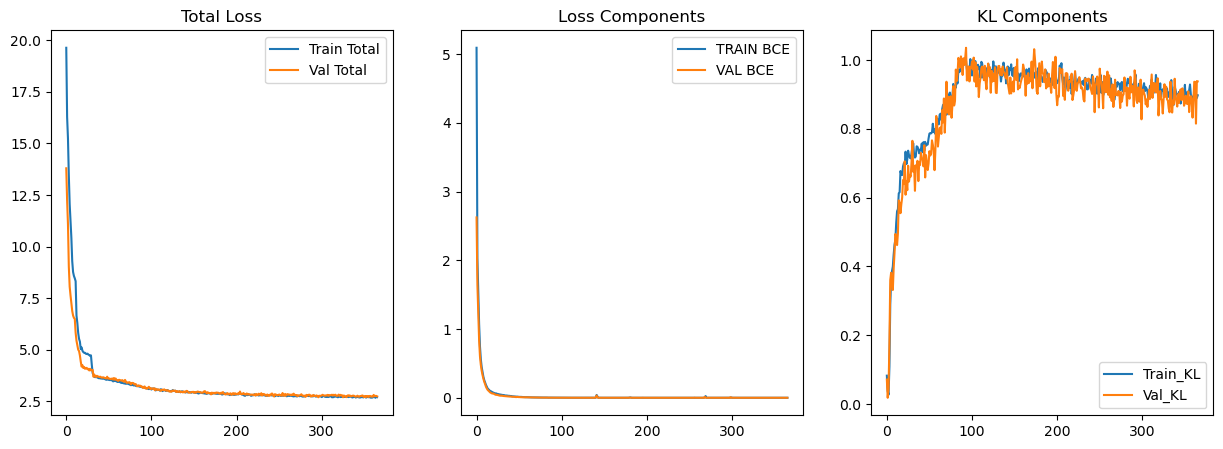

In [12]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

In [13]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 1) 환경 및 데이터 준비
x_scaler = joblib.load('torch/x_scaler.pkl')
c_scaler = joblib.load('torch/c_scaler.pkl')
test_loader = torch.load('torch/test_loader_a_r.pt', weights_only=False)


In [14]:
early_stopping.load_best_model(model)
model.eval()

all_x_true = [] #실제값(Scaled)
all_x_pred = [] # 복원값(Scaled)
all_mask_prob = [] # 존재확률 [0,1]
all_c_condition = [] # 사용된 조건(c)
all_c_true = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)

        mask_logits, prob_mask,recon_numeric,z_mu,z_logvar,pred_conversion= model(x_t,c_t)

        #확률 및 최종 복원값 계산
        prob_mask = torch.sigmoid(mask_logits)
        all_x_true.append(x_t.cpu().numpy())
        all_c_true.append(c_t.cpu().numpy())
        all_x_pred.append(recon_numeric.cpu().numpy())
        all_mask_prob.append(prob_mask.cpu().numpy())
        all_c_condition.append(pred_conversion.cpu().numpy())

all_x_true = np.vstack(all_x_true)
all_x_pred = np.vstack(all_x_pred)
all_c_condition = np.vstack(all_c_condition)
all_c_true = np.vstack(all_c_true)
all_mask_prob = np.vstack(all_mask_prob)
# all_x_pred = np.maximum(all_x_pred,0)
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_recon_raw = x_scaler.inverse_transform(all_x_pred)
c_recon_raw = c_scaler.inverse_transform(all_c_condition)
c_true_raw = c_scaler.inverse_transform(all_c_true)



Restored best model with loss: 2.700180


In [15]:
c_recon = c_recon_raw[:,-1]

In [16]:
c_recon

array([77.57791 , 68.00362 , 72.88269 , ..., 28.756054, 46.92964 ,
       44.34848 ], dtype=float32)

In [17]:
c_true = c_true_raw[:,-1]

In [18]:
c_true

array([90., 61., 97., ..., 43., 31., 60.], dtype=float32)

### ch4 r2_score

In [19]:
from sklearn.metrics import r2_score

# 1. 모든 컬럼을 합치지 말고, 각 변수(컬럼)별로 R2 계산
r2_per_column = r2_score(c_true_raw, c_recon_raw, multioutput='raw_values')

# 2. 결과 출력 (각 성분별로 점수가 나옵니다)
for i, score in enumerate(r2_per_column):
    print(f"Variable {i} R2 Score: {score:.4f}")

# 3. 전체 평균 (이게 진짜 모델의 평균 성능입니다)
print(f"Average R2 Score: {np.mean(r2_per_column):.4f}")

Variable 0 R2 Score: 0.3600
Variable 1 R2 Score: 0.7623
Variable 2 R2 Score: 0.7373
Variable 3 R2 Score: 0.9367
Variable 4 R2 Score: 0.7257
Variable 5 R2 Score: -0.1736
Variable 6 R2 Score: 0.4528
Variable 7 R2 Score: 0.6310
Variable 8 R2 Score: 0.1277
Average R2 Score: 0.5066


In [20]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = x_true_raw.flatten()
x_pred = x_recon_raw.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
r2

0.8467576503753662

In [21]:
standard_support = ['Al2O3_Gamma', 'Al2O3_Alpha', 'Al2O3_Mesoporous', 'BN', 'SBA-15', 'SiO2', 'MCM-41', 'ZSM-5', 'Si3N4', 'H-ZSM-5']
promot_support = ['LaNi0.9Ru0.1O3', 'LaNi0.8Ru0.2O3', 'La3.5Ru4O3', 'Sr0.92Y0.08Ti1.95Rh0.05O3', 'La2NiO4', 'LaCoO3', 'LaCuO3', 'LaRuO3', 'LaNiO3', 'LaMnO3', 'LaNiCoMnO3', 'La2Ni0.5F0.5O4', 'LaNi0.5Fe0.5O3', 'LaNi0.8Zn0.2O3', 'LaNi0.6Zn0.4O3', 'LaNi0.4Zn0.6O3', 'LaNi0.2Zn0.8O3', 'LaZnO3', 'La2O3', 'BaO', 'CaO', 'MgO', 'MgO_Nanocrystalline', 'MgAl2O4(nanocry)', 'CeO2', 'TiO2', 'PrO2', 'V2O5', 'ZrO2', 'nanocrystalline_ZrO2', 'MnO', 'Y2O3', 'MgAlOx', 'CoOx', 'Si3N4', 'H-ZSM-5', 'Ce0.8Pr0.2O2']
active_metal = ['Co', 'Cu', 'Ir', 'Mn', 'Ni', 'Pd', 'Pt', 'Rh', 'Ru','Fe']# 10
promoter = ['Ba', 'Ca', 'Ce', 'La', 'Ag', 'Mg', 'Au', 'K', 'Li', 'Pr', 'Sr', 'Y', 'Zr']#13

In [22]:
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.loc[:, active_metal].columns

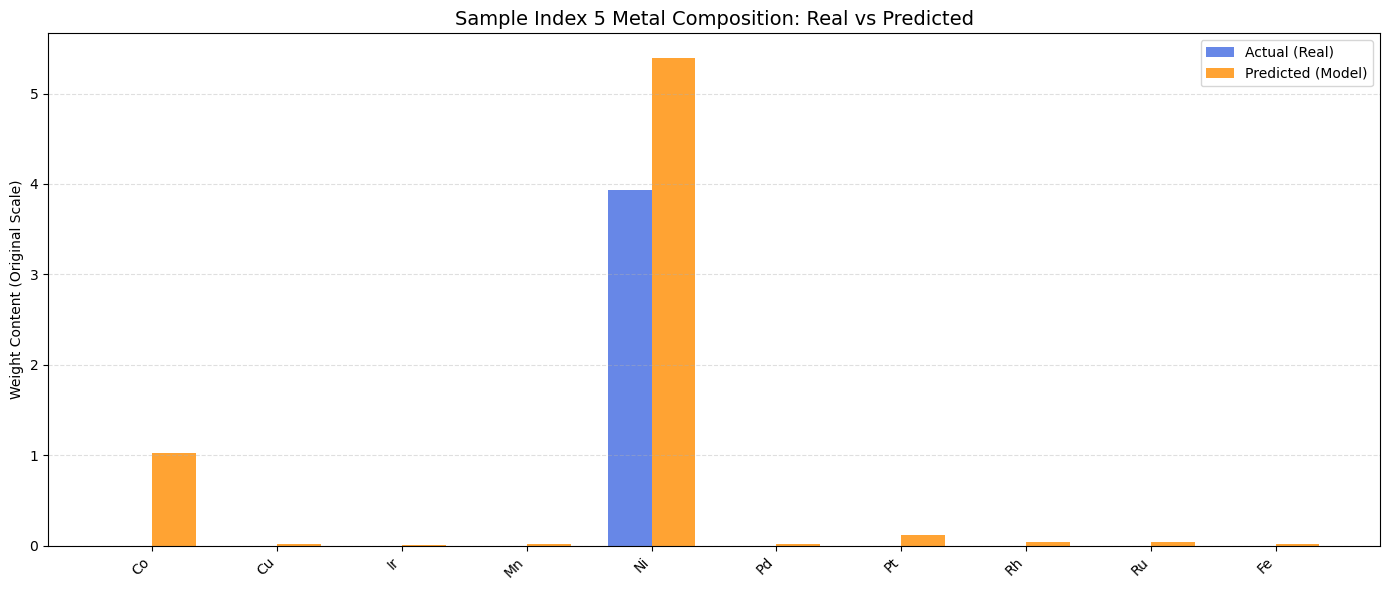

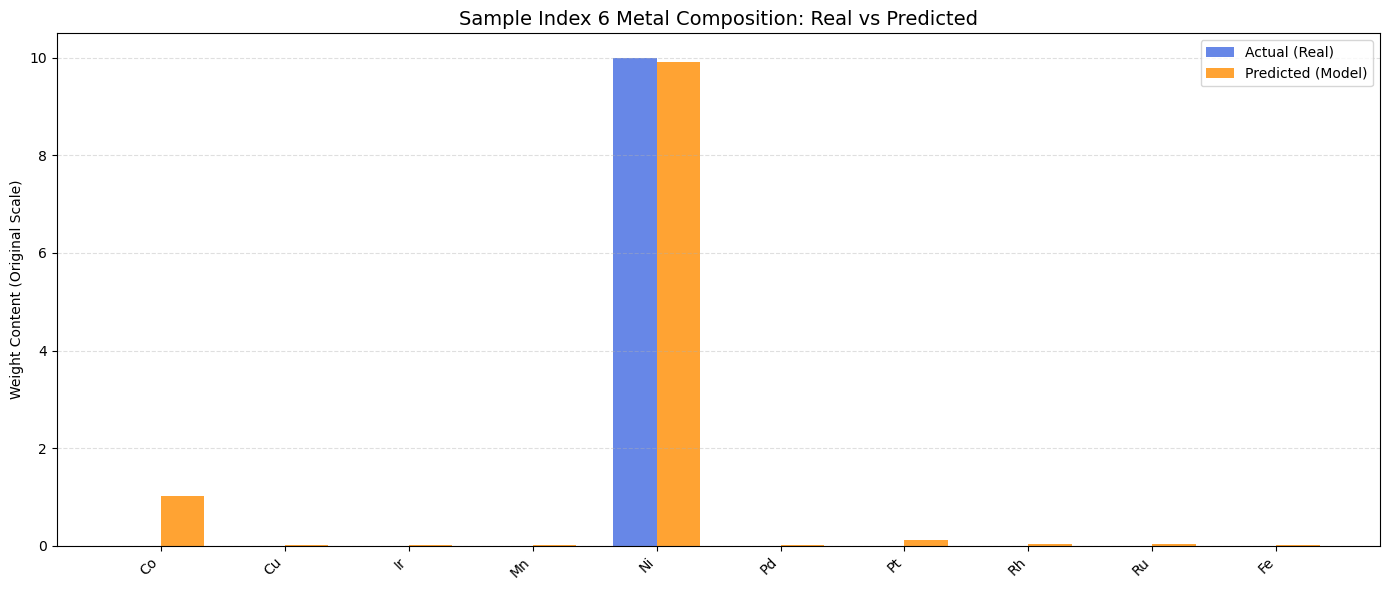

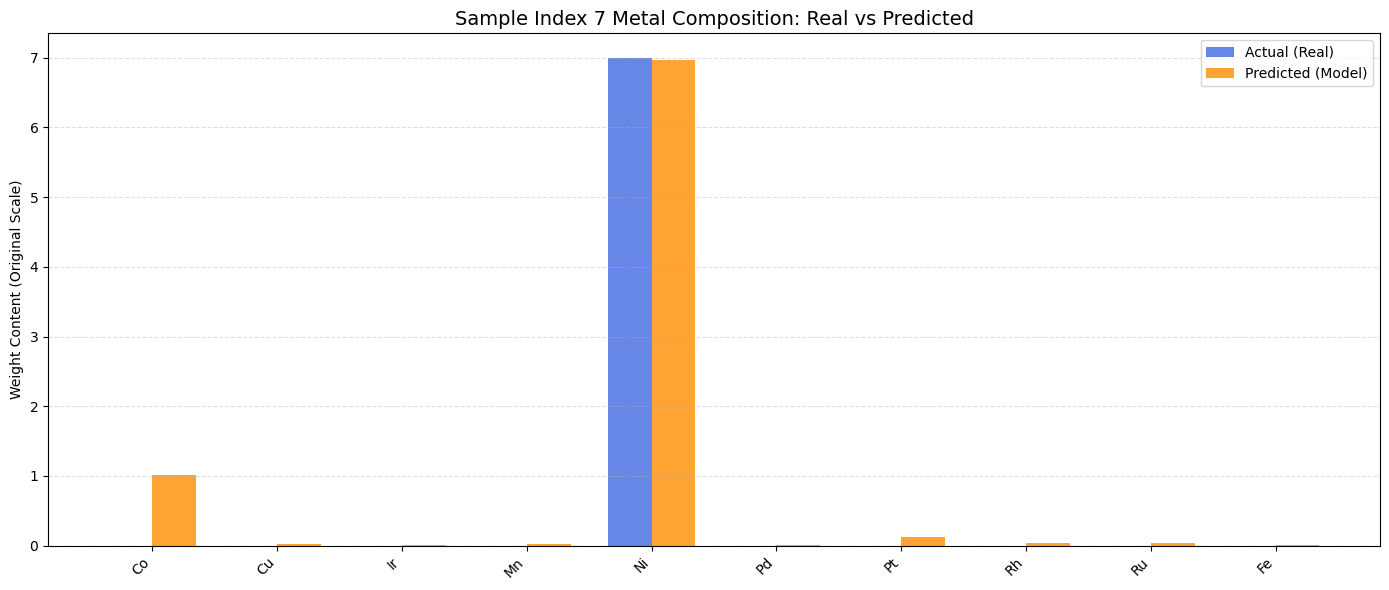

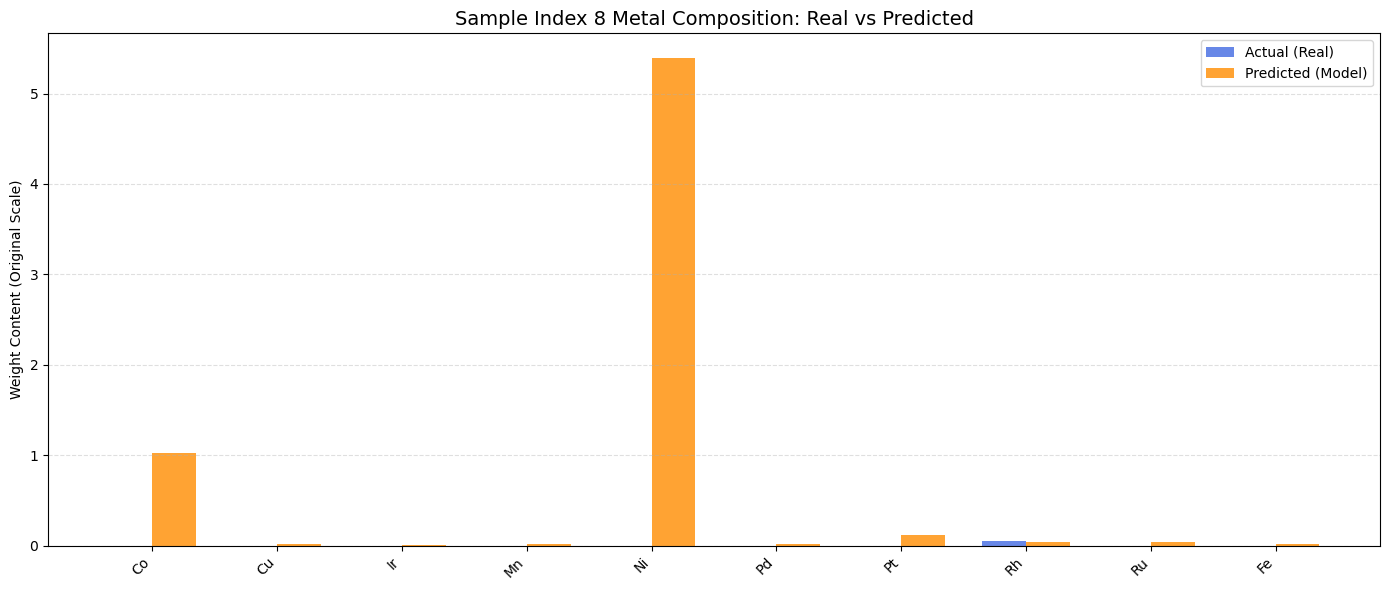

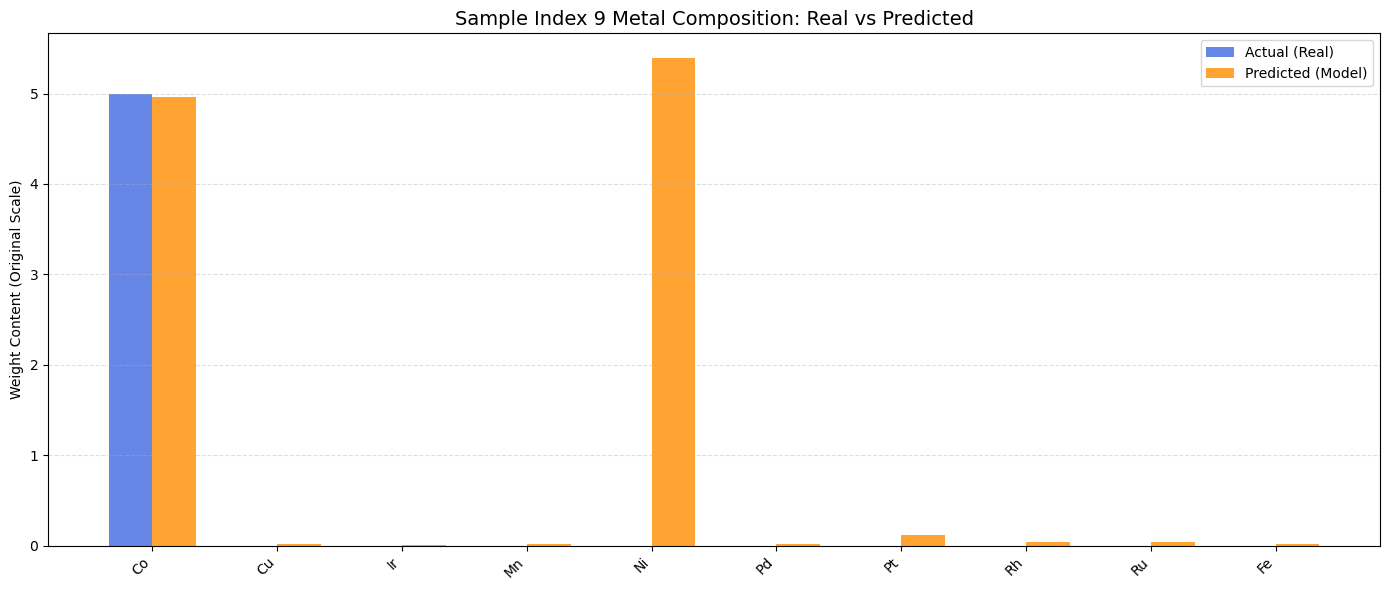

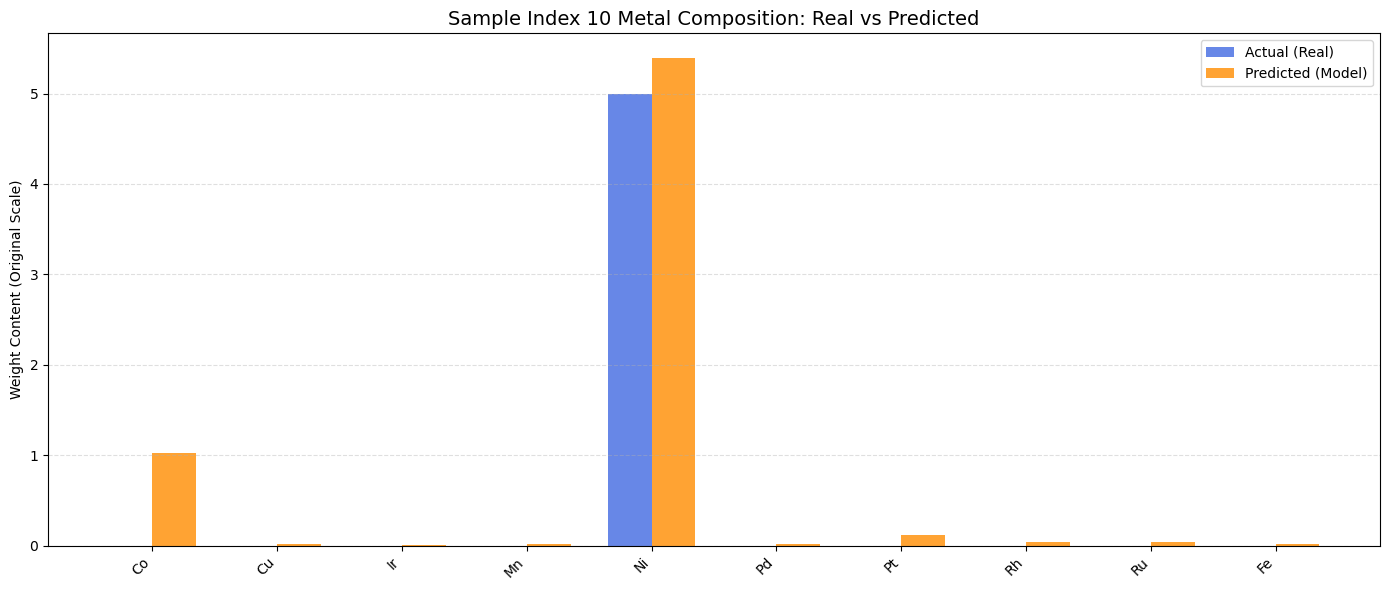

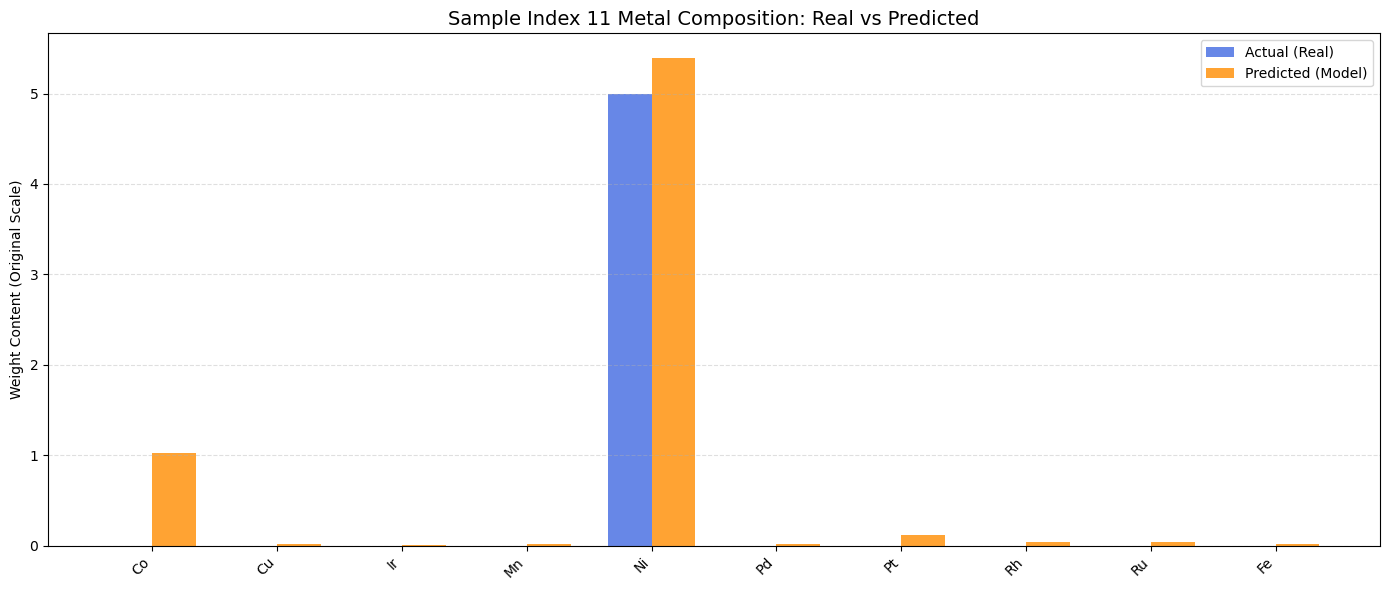

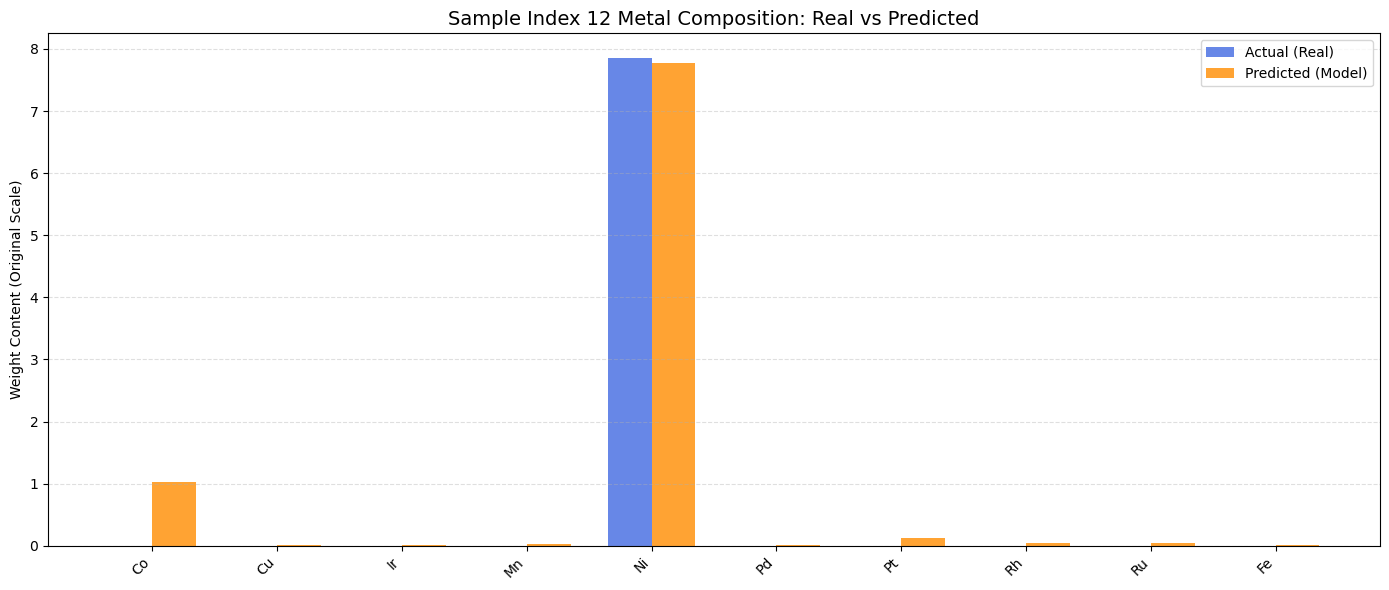

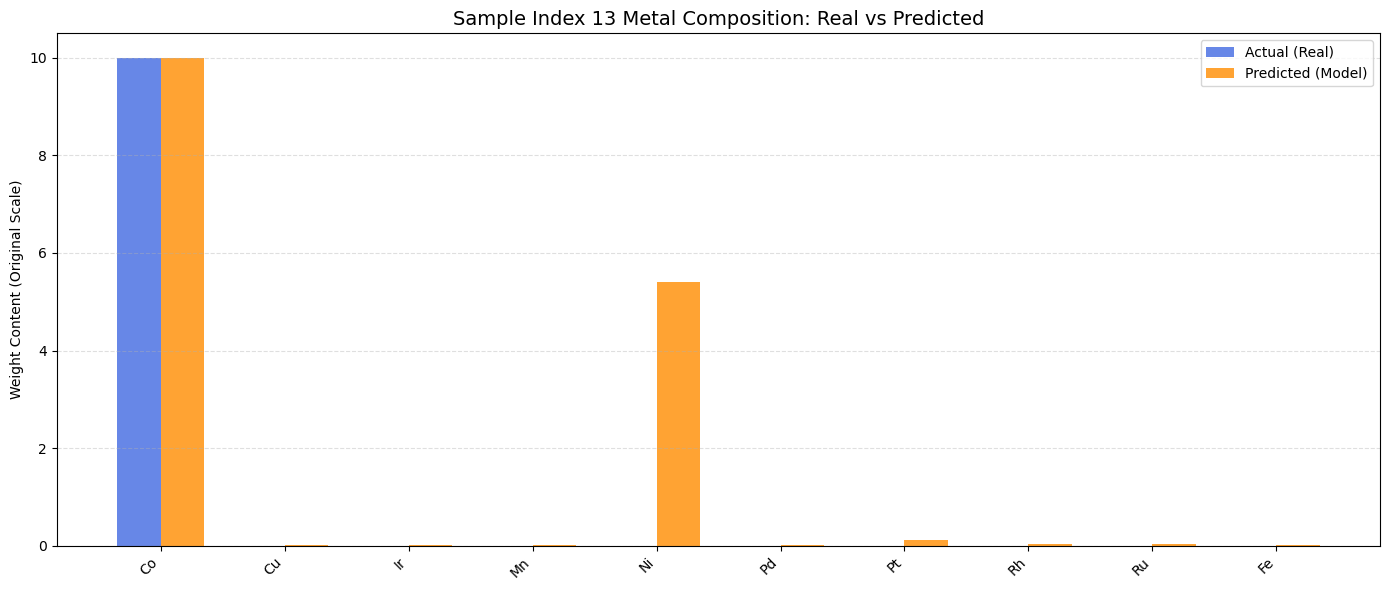

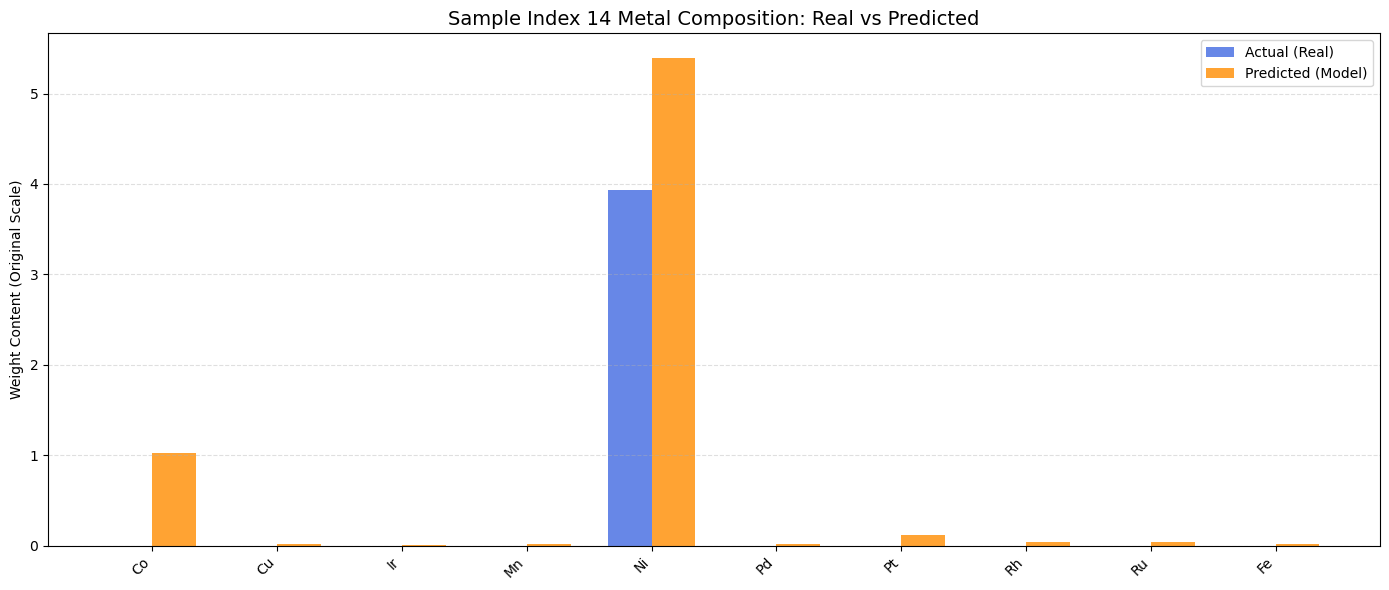

In [23]:
df_meta = pd.read_csv('211210-DRM-total.csv')
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.35
    
    plt.bar(x_axis - width/2, x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_recon_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()